In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import gseapy as gp
import seaborn as sns

from tqdm import tqdm
from scripts import constants

In [2]:
dataset = "mcfarland_2020"

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    )
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
target_indices = np.where(adata.obs["condition"] != "DMSO")[0]

In [5]:
genes = pd.read_table(
    os.path.join(
        "/projects/leelab/data/single-cell/mcfarland_2020",
        "idasanutlin/Idasanutlin_24hr_expt1",
        "genes.tsv",
    ),
    header=None,
)
genes = genes.rename(columns={0: "ensembl_id", 1: "gene_symbol"})
genes = genes[genes["ensembl_id"].isin(adata.var.index)]

In [6]:
"TP53" in genes["gene_symbol"]

False

In [7]:
seeds = [123, 42, 789, 46, 999]
latent_size = 10
result_list = []

for seed in tqdm(seeds):
    background_expr = np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}",
            "background_normalized_expression.npy",
        ),
    )
    salient_expr = np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}",
            "salient_normalized_expression.npy",
        ),
    )
    background_expr = background_expr[target_indices, :]
    salient_expr = salient_expr[target_indices, :]
    
    expr_mag_change = np.abs(salient_expr - background_expr)
    expr_mag_logfc = np.abs(np.log2(salient_expr / background_expr))
    
    results = genes.copy()
    results["mag_change_mean"] = np.mean(expr_mag_change, axis=0)
    results["mag_change_median"] = np.median(expr_mag_change, axis=0)
    results["mag_logfc_mean"] = np.mean(expr_mag_logfc, axis=0)
    results["mag_logfc_median"] = np.median(expr_mag_logfc, axis=0)
    results["seed"] = seed
    result_list.append(results)

results = pd.concat(result_list)
results = results.drop(columns=["ensembl_id"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


In [8]:
result_means = results.groupby("gene_symbol", as_index=False).mean().drop(columns=["seed"])

In [9]:
metric_list = [
    "mag_change_mean",
    "mag_change_median",
    "mag_logfc_mean",
    "mag_logfc_median",
]

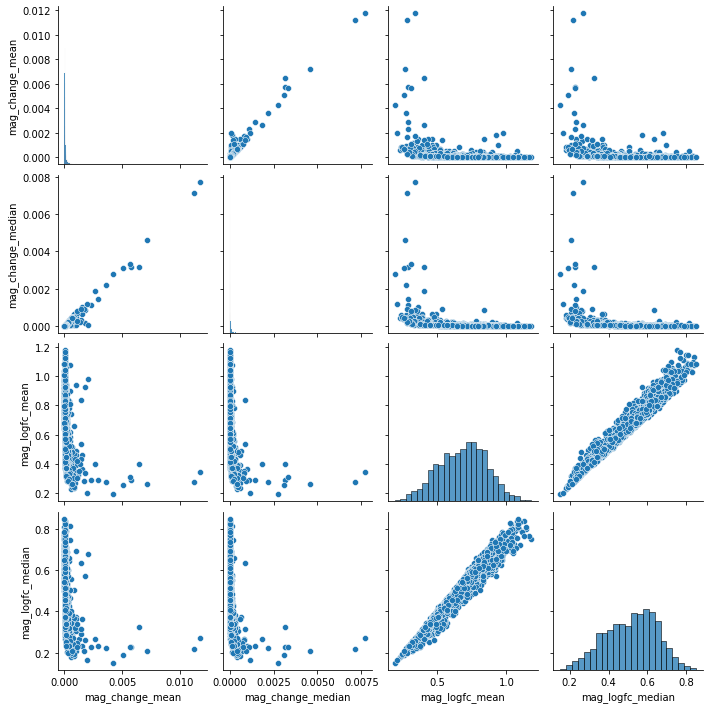

In [10]:
sns.pairplot(result_means[metric_list])

In [11]:
enr_result_dict = {}
top_gene_dict = {}
top_k = 100
for metric in metric_list:
    print(metric)
    sorted_genes = result_means.sort_values(by=metric, ascending=False)
    top_genes = sorted_genes.head(n=top_k)["gene_symbol"].tolist()
    enr = gp.enrichr(
        gene_list=top_genes,
        gene_sets="KEGG_2016",
        organism="human",
        cutoff=0.1,
    )
    enr_results = enr.results
    enr_results = enr_results[enr_results["Adjusted P-value"] < 0.1]
    enr_results = enr_results.sort_values(by="Adjusted P-value")
    
    enr_result_dict[metric] = enr_results
    top_gene_dict[metric] = top_genes

mag_change_mean
mag_change_median
mag_logfc_mean


2021-11-17 22:49:15,405 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.1


mag_logfc_median


In [12]:
enr_result_dict["mag_change_mean"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Glycolysis / Gluconeogenesis Homo sapiens hsa0...,7/67,4.296122e-08,0.000006,0,0,24.888889,422.189424,LDHB;LDHA;TPI1;PKM;ENO1;ALDOA;GAPDH
1,KEGG_2016,p53 signaling pathway Homo sapiens hsa04115,6/69,1.247776e-06,0.000088,0,0,20.098278,273.218948,CDKN1A;TP53I3;CCND1;GADD45A;IGFBP3;MDM2
2,KEGG_2016,Mineral absorption Homo sapiens hsa04978,5/51,5.529796e-06,0.000197,0,0,22.716247,274.988343,MT2A;FTH1;MT1X;MT1E;FTL
3,KEGG_2016,Prostate cancer Homo sapiens hsa05215,6/89,5.580858e-06,0.000197,0,0,15.239938,184.344857,CDKN1A;HSP90AA1;CCND1;GSTP1;MDM2;CTNNB1
4,KEGG_2016,Pathogenic Escherichia coli infection Homo sap...,5/55,8.060719e-06,0.000227,0,0,20.894737,245.064085,TUBA1C;TUBA1B;KRT18;TUBB;CTNNB1
5,KEGG_2016,HIF-1 signaling pathway Homo sapiens hsa04066,6/103,1.298024e-05,0.000305,0,0,13.031147,146.627545,LDHA;CDKN1A;EIF4EBP1;ENO1;ALDOA;GAPDH
6,KEGG_2016,Biosynthesis of amino acids Homo sapiens hsa01230,5/74,3.462786e-05,0.000698,0,0,15.126621,155.363284,TPI1;PKM;ENO1;ALDOA;GAPDH
7,KEGG_2016,Viral carcinogenesis Homo sapiens hsa05203,7/205,7.673517e-05,0.001352,0,0,7.489627,70.965347,RANBP1;CDKN1A;PKM;CCND1;HIST1H2BK;MDM2;HIST1H4C
8,KEGG_2016,Carbon metabolism Homo sapiens hsa01200,5/113,2.587519e-04,0.004054,0,0,9.645224,79.666088,TPI1;PKM;ENO1;ALDOA;GAPDH
9,KEGG_2016,Glioma Homo sapiens hsa05214,4/65,3.152627e-04,0.004054,0,0,13.551230,109.251427,CDKN1A;CCND1;MDM2;CALM2


In [13]:
enr_result_dict["mag_logfc_median"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Retinol metabolism Homo sapiens hsa00830,4/65,0.000315,0.027113,0,0,13.55123,109.251427,CYP26A1;UGT2B11;DHRS9;ALDH1A1
